In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.3.1


In [2]:
DATASET_PATH=os.path.join(os.getenv('HOME'),'aiffel/medical')
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


#### Visualization

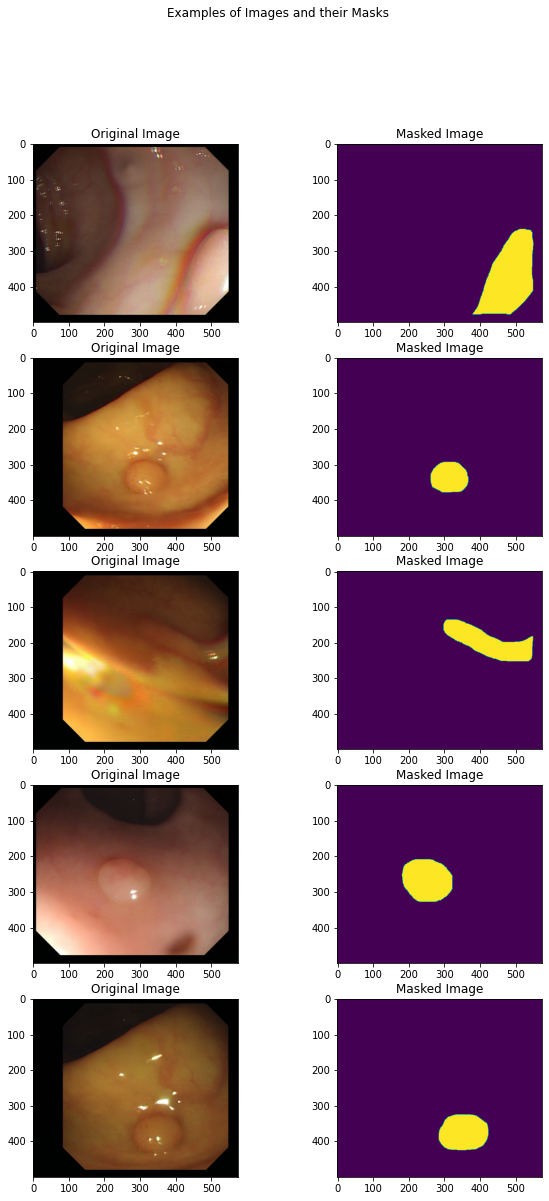

In [6]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 19))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

### STEP 1 : 데이터셋 구성
하이퍼파라미터 설정

In [7]:
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4 
max_epochs = 150

In [8]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [10]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [11]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

#### train, test 데이터셋 구성

In [12]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [13]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

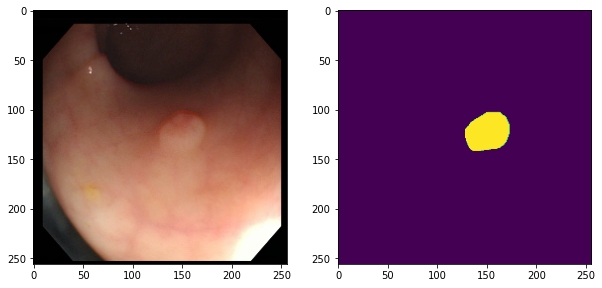

In [14]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

### STEP 2 : pretrained model을 활용한 U-Net 모델 구성

In [15]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                    include_top=False,
                                    weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Relu:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tens

#### Encoder-Decoder 모델

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

#### U-Net 모델

In [18]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [19]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [20]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

#### Vgg16-Unet 모델

In [21]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                                 include_top=False,
                                                 weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13],
                                               layer_outputs[17]])

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 
        
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

#### metrics와 loss functions 정의하기

In [22]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [23]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [24]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [25]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

### STEP 3 : 학습과 테스트, 시각화

In [26]:
ed_model = tf.keras.Sequential()
ed_model.add(encoder)
ed_model.add(decoder)
checkpoint_ed_dir = os.path.join(DATASET_PATH, 'train_ckpt/ed_model')

In [27]:
if not os.path.isdir(checkpoint_ed_dir):
    os.makedirs(checkpoint_ed_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_ed_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [28]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [29]:
ed_model.compile(optimizer=optimizer,
                 loss=bce_dice_loss,
                 metrics=[dice_loss])
predictions = ed_model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(4, 256, 256, 1)


In [30]:
ed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (4, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (4, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [31]:
ed_history = ed_model.fit(train_dataset,
                          epochs=max_epochs,    
                          steps_per_epoch=num_train_examples//batch_size,
                          validation_data=test_dataset,
                          validation_steps=num_test_examples//batch_size,
                          callbacks=[cp_callback, lr_callback]
                          )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/150
120/120 [==============================] - 6s 51ms/step - loss: 1.0156 - dice_loss: 0.7258 - val_loss: 6.2679 - val_dice_loss: 0.8972

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009998904, shape=(), dtype=float32).
Epoch 2/150
120/120 [==============================] - 6s 47ms/step - loss: 0.8425 - dice_loss: 0.6361 - val_loss: 3.7499 - val_dice_loss: 0.8778

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995615, shape=(), dtype=float32).
Epoch 3/150
120/120 [==============================] - 6s 47ms/step - loss: 0.7204 - dice_loss: 0.5469 - val_loss: 1.6292 - val_dice_loss: 0.8076

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 4/150
120/120 [==============================] - 6s 47ms/step - loss: 0.6189 - dice_loss: 0.4691 - val_loss: 1.1828

120/120 [==============================] - 5s 45ms/step - loss: 0.1220 - dice_loss: 0.0907 - val_loss: 0.2158 - val_dice_loss: 0.1696

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.000898265, shape=(), dtype=float32).
Epoch 32/150
120/120 [==============================] - 5s 45ms/step - loss: 0.1089 - dice_loss: 0.0801 - val_loss: 0.2077 - val_dice_loss: 0.1645

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.0008918468, shape=(), dtype=float32).
Epoch 33/150
120/120 [==============================] - 5s 45ms/step - loss: 0.1164 - dice_loss: 0.0859 - val_loss: 0.2431 - val_dice_loss: 0.1876

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(0.0008852567, shape=(), dtype=float32).
Epoch 34/150
120/120 [==============================] - 6s 47ms/step - loss: 0.0903 - dice_loss: 0.0663 - val_loss: 0.1341 - val_dice_loss: 0.1022

Epoch 00035: LearningRateScheduler reducing learning rate to tf.Tensor(0.00087849755, sha

120/120 [==============================] - 5s 45ms/step - loss: 0.0488 - dice_loss: 0.0361 - val_loss: 0.0884 - val_dice_loss: 0.0680

Epoch 00064: LearningRateScheduler reducing learning rate to tf.Tensor(0.00062434503, shape=(), dtype=float32).
Epoch 64/150
120/120 [==============================] - 5s 45ms/step - loss: 0.0479 - dice_loss: 0.0355 - val_loss: 0.0810 - val_dice_loss: 0.0629

Epoch 00065: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006141754, shape=(), dtype=float32).
Epoch 65/150
120/120 [==============================] - 5s 45ms/step - loss: 0.0470 - dice_loss: 0.0348 - val_loss: 0.0778 - val_dice_loss: 0.0588

Epoch 00066: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006039558, shape=(), dtype=float32).
Epoch 66/150
120/120 [==============================] - 6s 47ms/step - loss: 0.0469 - dice_loss: 0.0347 - val_loss: 0.0737 - val_dice_loss: 0.0567

Epoch 00067: LearningRateScheduler reducing learning rate to tf.Tensor(0.00059369067, s

120/120 [==============================] - 5s 45ms/step - loss: 0.0380 - dice_loss: 0.0284 - val_loss: 0.5418 - val_dice_loss: 0.3849

Epoch 00096: LearningRateScheduler reducing learning rate to tf.Tensor(0.00029663168, shape=(), dtype=float32).
Epoch 96/150
120/120 [==============================] - 6s 47ms/step - loss: 0.0377 - dice_loss: 0.0280 - val_loss: 0.0592 - val_dice_loss: 0.0445

Epoch 00097: LearningRateScheduler reducing learning rate to tf.Tensor(0.00028711034, shape=(), dtype=float32).
Epoch 97/150
120/120 [==============================] - 5s 45ms/step - loss: 0.0335 - dice_loss: 0.0247 - val_loss: 0.0710 - val_dice_loss: 0.0537

Epoch 00098: LearningRateScheduler reducing learning rate to tf.Tensor(0.00027768244, shape=(), dtype=float32).
Epoch 98/150
120/120 [==============================] - 5s 45ms/step - loss: 0.0331 - dice_loss: 0.0243 - val_loss: 0.0638 - val_dice_loss: 0.0485

Epoch 00099: LearningRateScheduler reducing learning rate to tf.Tensor(0.000268352, s


Epoch 00127: LearningRateScheduler reducing learning rate to tf.Tensor(6.184671e-05, shape=(), dtype=float32).
Epoch 127/150
120/120 [==============================] - 6s 47ms/step - loss: 0.0265 - dice_loss: 0.0194 - val_loss: 0.0557 - val_dice_loss: 0.0418

Epoch 00128: LearningRateScheduler reducing learning rate to tf.Tensor(5.689821e-05, shape=(), dtype=float32).
Epoch 128/150
120/120 [==============================] - 5s 45ms/step - loss: 0.0262 - dice_loss: 0.0193 - val_loss: 0.0587 - val_dice_loss: 0.0443

Epoch 00129: LearningRateScheduler reducing learning rate to tf.Tensor(5.214408e-05, shape=(), dtype=float32).
Epoch 129/150
120/120 [==============================] - 5s 45ms/step - loss: 0.0264 - dice_loss: 0.0195 - val_loss: 0.0597 - val_dice_loss: 0.0448

Epoch 00130: LearningRateScheduler reducing learning rate to tf.Tensor(4.7586444e-05, shape=(), dtype=float32).
Epoch 130/150
120/120 [==============================] - 5s 45ms/step - loss: 0.0256 - dice_loss: 0.0187 - 

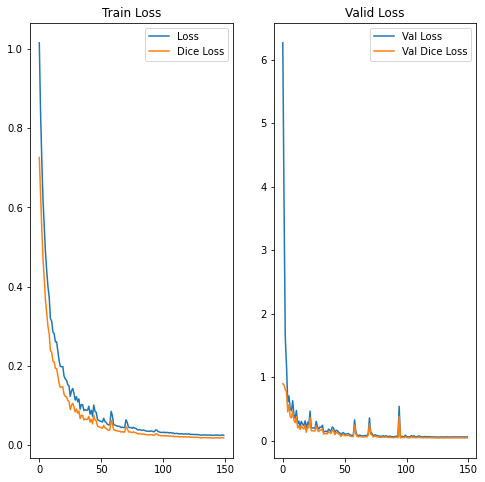

In [32]:
val_dice_loss = ed_history.history['val_dice_loss']
val_loss = ed_history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, ed_history.history['loss'], label='Loss')
plt.plot(epochs_range, ed_history.history['dice_loss'], label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [33]:
unet_model = UNet()
checkpoint_unet_dir = os.path.join(DATASET_PATH,'train_ckpt/unet_model')

In [34]:
if not os.path.isdir(checkpoint_unet_dir):
    os.makedirs(checkpoint_unet_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_unet_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [35]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [36]:
unet_model.compile(optimizer=optimizer,
                   loss=bce_dice_loss,
                   metrics=[dice_loss])
predictions = unet_model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(4, 256, 256, 1)


In [37]:
unet_model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [38]:
unet_history = unet_model.fit(train_dataset,
                              epochs=max_epochs,    
                              steps_per_epoch=num_train_examples//batch_size,
                              validation_data=test_dataset,
                              validation_steps=num_test_examples//batch_size,
                              callbacks=[cp_callback, lr_callback]
                              )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/150
120/120 [==============================] - 25s 210ms/step - loss: 0.9388 - dice_loss: 0.7129 - val_loss: 1.2131 - val_dice_loss: 0.8706

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009998904, shape=(), dtype=float32).
Epoch 2/150
120/120 [==============================] - 24s 199ms/step - loss: 0.8986 - dice_loss: 0.6980 - val_loss: 1.0177 - val_dice_loss: 0.8494

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995615, shape=(), dtype=float32).
Epoch 3/150
120/120 [==============================] - 24s 199ms/step - loss: 0.8955 - dice_loss: 0.6953 - val_loss: 0.9201 - val_dice_loss: 0.7190

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 4/150
120/120 [==============================] - 24s 197ms/step - loss: 0.8941 - dice_loss: 0.6938 - val_loss

120/120 [==============================] - 22s 186ms/step - loss: 0.1611 - dice_loss: 0.1182 - val_loss: 0.2516 - val_dice_loss: 0.1999

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
Epoch 31/150
120/120 [==============================] - 24s 198ms/step - loss: 0.1641 - dice_loss: 0.1217 - val_loss: 0.2016 - val_dice_loss: 0.1539

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.000898265, shape=(), dtype=float32).
Epoch 32/150
120/120 [==============================] - 22s 186ms/step - loss: 0.1486 - dice_loss: 0.1091 - val_loss: 0.2273 - val_dice_loss: 0.1784

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.0008918468, shape=(), dtype=float32).
Epoch 33/150
120/120 [==============================] - 22s 186ms/step - loss: 0.1627 - dice_loss: 0.1194 - val_loss: 0.2334 - val_dice_loss: 0.1820

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(0.00088525


Epoch 00062: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006445159, shape=(), dtype=float32).
Epoch 62/150
120/120 [==============================] - 22s 186ms/step - loss: 0.0640 - dice_loss: 0.0472 - val_loss: 0.1110 - val_dice_loss: 0.0853

Epoch 00063: LearningRateScheduler reducing learning rate to tf.Tensor(0.00063445995, shape=(), dtype=float32).
Epoch 63/150
120/120 [==============================] - 22s 186ms/step - loss: 0.0762 - dice_loss: 0.0554 - val_loss: 0.1282 - val_dice_loss: 0.1002

Epoch 00064: LearningRateScheduler reducing learning rate to tf.Tensor(0.00062434503, shape=(), dtype=float32).
Epoch 64/150
120/120 [==============================] - 22s 186ms/step - loss: 0.0710 - dice_loss: 0.0522 - val_loss: 0.0981 - val_dice_loss: 0.0761

Epoch 00065: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006141754, shape=(), dtype=float32).
Epoch 65/150
120/120 [==============================] - 22s 186ms/step - loss: 0.0577 - dice_loss: 0.04

120/120 [==============================] - 22s 186ms/step - loss: 0.0411 - dice_loss: 0.0304 - val_loss: 0.0836 - val_dice_loss: 0.0653

Epoch 00094: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 94/150
120/120 [==============================] - 22s 186ms/step - loss: 0.0432 - dice_loss: 0.0323 - val_loss: 0.0643 - val_dice_loss: 0.0495

Epoch 00095: LearningRateScheduler reducing learning rate to tf.Tensor(0.00030624223, shape=(), dtype=float32).
Epoch 95/150
120/120 [==============================] - 22s 186ms/step - loss: 0.0380 - dice_loss: 0.0280 - val_loss: 0.0688 - val_dice_loss: 0.0521

Epoch 00096: LearningRateScheduler reducing learning rate to tf.Tensor(0.00029663168, shape=(), dtype=float32).
Epoch 96/150
120/120 [==============================] - 22s 186ms/step - loss: 0.0384 - dice_loss: 0.0282 - val_loss: 0.0706 - val_dice_loss: 0.0550

Epoch 00097: LearningRateScheduler reducing learning rate to tf.Tensor(0.00028

120/120 [==============================] - 24s 203ms/step - loss: 0.0312 - dice_loss: 0.0229 - val_loss: 0.0599 - val_dice_loss: 0.0459

Epoch 00125: LearningRateScheduler reducing learning rate to tf.Tensor(7.2317875e-05, shape=(), dtype=float32).
Epoch 125/150
120/120 [==============================] - 24s 198ms/step - loss: 0.0308 - dice_loss: 0.0226 - val_loss: 0.0595 - val_dice_loss: 0.0459

Epoch 00126: LearningRateScheduler reducing learning rate to tf.Tensor(6.698731e-05, shape=(), dtype=float32).
Epoch 126/150
120/120 [==============================] - 22s 185ms/step - loss: 0.0315 - dice_loss: 0.0233 - val_loss: 0.0615 - val_dice_loss: 0.0473

Epoch 00127: LearningRateScheduler reducing learning rate to tf.Tensor(6.184671e-05, shape=(), dtype=float32).
Epoch 127/150
120/120 [==============================] - 22s 185ms/step - loss: 0.0305 - dice_loss: 0.0224 - val_loss: 0.0617 - val_dice_loss: 0.0471

Epoch 00128: LearningRateScheduler reducing learning rate to tf.Tensor(5.689

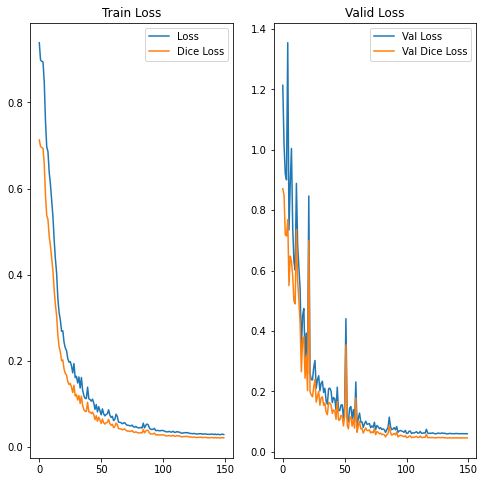

In [39]:
val_dice_loss = unet_history.history['val_dice_loss']
val_loss = unet_history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, unet_history.history['loss'], label='Loss')
plt.plot(epochs_range, unet_history.history['dice_loss'], label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [40]:
vgg16unet_model = Vgg16UNet()
checkpoint_vgg16unet_dir = os.path.join(DATASET_PATH, 'train_ckpt/vgg16unet_model')

In [41]:
if not os.path.isdir(checkpoint_vgg16unet_dir):
    os.makedirs(checkpoint_vgg16unet_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_vgg16unet_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [42]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [43]:
vgg16unet_model.compile(optimizer=optimizer,
                        loss=bce_dice_loss,
                        metrics=[dice_loss])
predictions = vgg16unet_model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(4, 256, 256, 1)


In [44]:
vgg16unet_history = vgg16unet_model.fit(train_dataset,
                                        epochs=max_epochs,    
                                        steps_per_epoch=num_train_examples//batch_size,
                                        validation_data=test_dataset,
                                        validation_steps=num_test_examples//batch_size,
                                        callbacks=[cp_callback, lr_callback]
                                        )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/150
120/120 [==============================] - 16s 136ms/step - loss: 0.9293 - dice_loss: 0.7126 - val_loss: 1.0596 - val_dice_loss: 0.7290

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009998904, shape=(), dtype=float32).
Epoch 2/150
120/120 [==============================] - 15s 124ms/step - loss: 0.9015 - dice_loss: 0.6982 - val_loss: 1.1313 - val_dice_loss: 0.7372

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995615, shape=(), dtype=float32).
Epoch 3/150
120/120 [==============================] - 16s 131ms/step - loss: 0.8875 - dice_loss: 0.6892 - val_loss: 1.0370 - val_dice_loss: 0.8650

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 4/150
120/120 [==============================] - 15s 123ms/step - loss: 0.8785 - dice_loss: 0.6822 - val_loss

120/120 [==============================] - 16s 132ms/step - loss: 0.2099 - dice_loss: 0.1570 - val_loss: 0.2098 - val_dice_loss: 0.1641

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
Epoch 31/150
120/120 [==============================] - 16s 130ms/step - loss: 0.1747 - dice_loss: 0.1285 - val_loss: 0.1809 - val_dice_loss: 0.1400

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.000898265, shape=(), dtype=float32).
Epoch 32/150
120/120 [==============================] - 15s 123ms/step - loss: 0.1765 - dice_loss: 0.1310 - val_loss: 0.2761 - val_dice_loss: 0.2119

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.0008918468, shape=(), dtype=float32).
Epoch 33/150
120/120 [==============================] - 15s 128ms/step - loss: 0.1681 - dice_loss: 0.1240 - val_loss: 0.1769 - val_dice_loss: 0.1344

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(0.00088525


Epoch 00062: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006445159, shape=(), dtype=float32).
Epoch 62/150
120/120 [==============================] - 15s 123ms/step - loss: 0.0759 - dice_loss: 0.0555 - val_loss: 0.1080 - val_dice_loss: 0.0836

Epoch 00063: LearningRateScheduler reducing learning rate to tf.Tensor(0.00063445995, shape=(), dtype=float32).
Epoch 63/150
120/120 [==============================] - 15s 123ms/step - loss: 0.0720 - dice_loss: 0.0529 - val_loss: 0.1843 - val_dice_loss: 0.1407

Epoch 00064: LearningRateScheduler reducing learning rate to tf.Tensor(0.00062434503, shape=(), dtype=float32).
Epoch 64/150
120/120 [==============================] - 15s 123ms/step - loss: 0.0868 - dice_loss: 0.0638 - val_loss: 0.1246 - val_dice_loss: 0.0978

Epoch 00065: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006141754, shape=(), dtype=float32).
Epoch 65/150
120/120 [==============================] - 15s 123ms/step - loss: 0.0831 - dice_loss: 0.06

120/120 [==============================] - 15s 123ms/step - loss: 0.0424 - dice_loss: 0.0311 - val_loss: 0.0776 - val_dice_loss: 0.0579

Epoch 00094: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 94/150
120/120 [==============================] - 15s 123ms/step - loss: 0.0426 - dice_loss: 0.0314 - val_loss: 0.0758 - val_dice_loss: 0.0569

Epoch 00095: LearningRateScheduler reducing learning rate to tf.Tensor(0.00030624223, shape=(), dtype=float32).
Epoch 95/150
120/120 [==============================] - 15s 123ms/step - loss: 0.0412 - dice_loss: 0.0301 - val_loss: 0.0740 - val_dice_loss: 0.0553

Epoch 00096: LearningRateScheduler reducing learning rate to tf.Tensor(0.00029663168, shape=(), dtype=float32).
Epoch 96/150
120/120 [==============================] - 15s 124ms/step - loss: 0.0410 - dice_loss: 0.0302 - val_loss: 0.0720 - val_dice_loss: 0.0538

Epoch 00097: LearningRateScheduler reducing learning rate to tf.Tensor(0.00028

120/120 [==============================] - 15s 123ms/step - loss: 0.0321 - dice_loss: 0.0235 - val_loss: 0.0691 - val_dice_loss: 0.0509

Epoch 00125: LearningRateScheduler reducing learning rate to tf.Tensor(7.2317875e-05, shape=(), dtype=float32).
Epoch 125/150
120/120 [==============================] - 15s 124ms/step - loss: 0.0317 - dice_loss: 0.0232 - val_loss: 0.0716 - val_dice_loss: 0.0521

Epoch 00126: LearningRateScheduler reducing learning rate to tf.Tensor(6.698731e-05, shape=(), dtype=float32).
Epoch 126/150
120/120 [==============================] - 15s 124ms/step - loss: 0.0316 - dice_loss: 0.0230 - val_loss: 0.0712 - val_dice_loss: 0.0520

Epoch 00127: LearningRateScheduler reducing learning rate to tf.Tensor(6.184671e-05, shape=(), dtype=float32).
Epoch 127/150
120/120 [==============================] - 15s 123ms/step - loss: 0.0315 - dice_loss: 0.0231 - val_loss: 0.0708 - val_dice_loss: 0.0517

Epoch 00128: LearningRateScheduler reducing learning rate to tf.Tensor(5.689

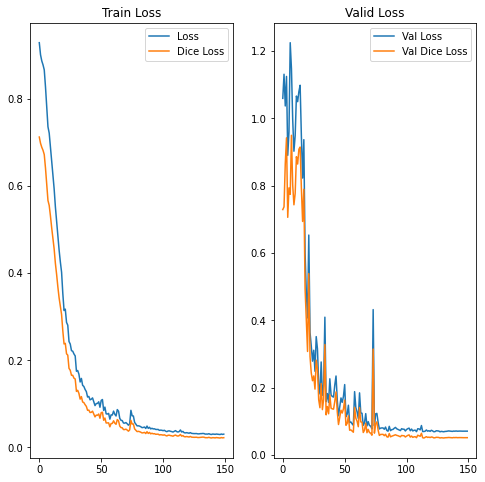

In [45]:
val_dice_loss = vgg16unet_history.history['val_dice_loss']
val_loss = vgg16unet_history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, vgg16unet_history.history['loss'], label='Loss')
plt.plot(epochs_range, vgg16unet_history.history['dice_loss'], label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [46]:
# ed_model.load_weights(checkpoint_ed_dir)
# unet_model.load_weights(checkpoint_unet_dir)
# vgg16unet_model.load_weights(checkpoint_vgg16unet_dir)

In [47]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [48]:
mean = []

for images, labels in test_dataset:
    predictions = ed_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("ED Model")
print("mean_iou: {}".format(mean))

ED Model
mean_iou: 0.9429772716781599


In [49]:
mean = []

for images, labels in test_dataset:
    predictions = unet_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("U-Net Model")
print("mean_iou: {}".format(mean))

U-Net Model
mean_iou: 0.9415617869516261


In [50]:
mean = []

for images, labels in test_dataset:
    predictions = vgg16unet_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("Vgg16_UNet Model")
print("mean_iou: {}".format(mean))

Vgg16_UNet Model
mean_iou: 0.9378216931272579


In [51]:
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

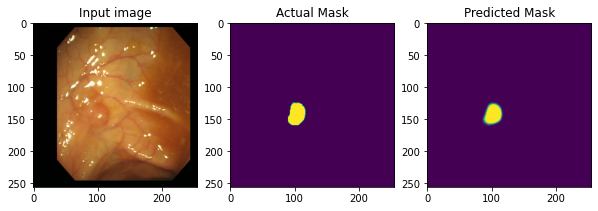

In [52]:
print_images(ed_model)

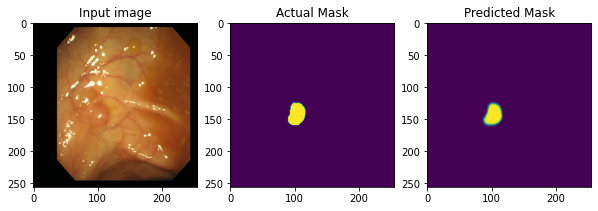

In [53]:
print_images(unet_model)

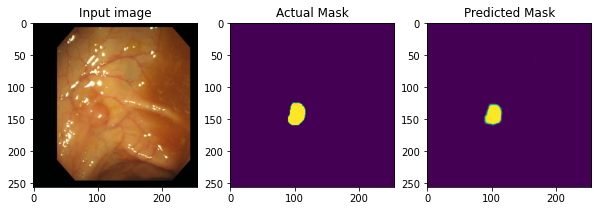

In [54]:
print_images(vgg16unet_model)

##### Batch_size = 2일 경우
ED Model         mean_iou: 0.9268860292899748  
U-Net Model      mean_iou: 0.9373790815890687  
Vgg16_UNet Model mean_iou: 0.9189400773398331  
##### Batch_size = 4일 경우  
ED Model         mean_iou: 0.9406361372119734  
U-Net Model      mean_iou: 0.9419867815211288  
Vgg16_UNet Model mean_iou: 0.9434509615095705  
##### Batch_size = 8일 경우  
ED Model         mean_iou: 0.9418569812844346  
U-Net Model      mean_iou: 0.9430038991551936  
Vgg16_UNet Model mean_iou: 0.9319521136143009  
##### Batch_size = 16일 경우
ED Model         mean_iou: 0.9421193069761443  
U-Net Model      mean_iou: 0.9460828587295964  
Vgg16_UNet Model mean_iou: 0.9114396817595009  
##### Batch_size = 32일 경우  
ED Model         mean_iou: 0.9409711802681144  
U-Net Model      mean_iou: 0.9401560877280106   
Vgg16_UNet Model mean_iou: 0.8529196546535738  

Batch_size을 늘릴수록 ed, unet모델은 일정하게 iou값이 증가하지만 pretrained model은 4일 경우 제일 높았다.  
32일 경우 오히려 하락